In [1]:
import itertools as it
import time

import heapq

import pandas as pd
import numpy as np
np.random.seed(1337)


dataset_A = pd.read_csv('../TSPA.csv', sep=';', names=['x', 'y', 'cost'])
dataset_B = pd.read_csv('../TSPB.csv', sep=';', names=['x', 'y', 'cost'])

datasets = [dataset_A, dataset_B]

dataset_A.shape, dataset_B.shape

((200, 3), (200, 3))

In [2]:
node1, node2 = dataset_B.iloc[177], dataset_B.iloc[43]

print(f'{node1}\n\n{node2}')

x       1450
y        398
cost      52
Name: 177, dtype: int64

x       1654
y       1486
cost     638
Name: 43, dtype: int64


In [3]:
def euclidean_distance(node1, node2):
    return np.int32(((node1['x'] - node2['x']) ** 2 + (node1['y'] - node2['y']) ** 2) ** 0.5 + 0.5)

In [4]:
print(f'distance between node1 and node2 = {euclidean_distance(node1, node2)}')

distance between node1 and node2 = 1107


In [5]:
def nodes_cost(node1, node2):
    return node1['cost'] + node2['cost']

In [6]:
print(f'objective function of node1 and node2 = {euclidean_distance(node1, node2) + nodes_cost(node1, node2)}')

objective function of node1 and node2 = 1797


In [7]:
def calculate_function_cost(dataset: pd.DataFrame, solution: list) -> int:
    if not solution:
        return 0
    
    cost = 0
    for node in solution:
        cost += dataset.at[node, "cost"]
    
    for i in range(len(solution)):
        node1 = dataset.iloc[solution[i]]
        node2 = dataset.iloc[solution[(i + 1) % len(solution)]]
        cost += euclidean_distance(node1, node2)
    
    return int(cost)

In [8]:
def calculate_distance_matrix(dataset):
    n_nodes = len(dataset)
    distance_matrix = np.zeros((n_nodes, n_nodes), dtype=np.float64)
    for i, j in it.product(range(n_nodes), range(n_nodes)):
        if i == j:
            continue
        a, b = dataset.iloc[i], dataset.iloc[j]
        distance_matrix[i, j] = euclidean_distance(a, b) + nodes_cost(a, b)
    return distance_matrix

In [9]:
distance_matrix_A = calculate_distance_matrix(dataset_A)
distance_matrix_B = calculate_distance_matrix(dataset_B)

In [10]:
print(f'objective function of node1 and node2 = {distance_matrix_A[177, 43]}')

objective function of node1 and node2 = 1831.0


In [11]:
import matplotlib.pyplot as plt

import seaborn as sns

def plot(dataset, solution, title):
    max_x = dataset['x'].max()
    max_y = dataset['y'].max()

    aspect_ratio = int(max_x / max_y)

    if max_x > max_y:
        height = 6.0
        width = height * aspect_ratio
    else:
        width = 6.0
        height = width * aspect_ratio

    sns.set_theme(rc={'figure.figsize': (width, height)})

    sns.scatterplot(
        data=dataset,
        x='x',
        y='y',
        size='cost',
        legend=False
    )

    for i in range(-1, len(solution) - 1):
        idx1 = solution[i]
        idx2 = solution[i + 1]
        x_values = [dataset.loc[idx1, "x"], dataset.loc[idx2, "x"]]
        y_values = [dataset.loc[idx1, "y"], dataset.loc[idx2, "y"]]
        plt.plot(
            x_values,
            y_values,
            color="b",
            linestyle="-",
        )
    

    
    plt.title(title)
    plt.show();

# Local Search



In [12]:
def init_random_solution(dataset: pd.DataFrame, distance_matrix: pd.DataFrame, start: int) -> list:
    selected_count = int(len(dataset) * 0.5 + 0.5)
    return dataset.sample(n=selected_count).index.tolist()

In [13]:
def objective_change_two_nodes(dm: np.ndarray, solution: list, i: int, j: int) -> float:
    if i == j:
        return 0.0

    n = len(solution)
    a, b = solution[i], solution[j]

    a_prev = solution[i - 1] if i > 0 else solution[-1]
    a_next = solution[(i + 1) % n]
    b_prev = solution[j - 1] if j > 0 else solution[-1]
    b_next = solution[(j + 1) % n]

    edges_removed = []
    edges_added = []

    if a_prev not in (a, b):
        edges_removed.append((a_prev, a))
        edges_added.append((a_prev, b))
    if a_next not in (a, b):
        edges_removed.append((a, a_next))
        edges_added.append((b, a_next))
    if b_prev not in (a, b):
        edges_removed.append((b_prev, b))
        edges_added.append((b_prev, a))
    if b_next not in (a, b):
        edges_removed.append((b, b_next))
        edges_added.append((a, b_next))

    delta = -sum(dm[u, v] for u, v in edges_removed) + sum(
        dm[u, v] for u, v in edges_added
    )

    return delta

def objective_change_two_edges(dm: np.ndarray, solution: list, i: int, j: int) -> float:
    if i >= j or (i == 0 and j == len(solution) - 1):
        return 0.0

    n = len(solution)
    a_prev = solution[i - 1] if i > 0 else solution[-1]
    a = solution[i]
    b = solution[j]
    b_next = solution[(j + 1) % n]

    cost_before = dm[a_prev, a] + dm[b, b_next]
    cost_after = dm[a_prev, b] + dm[a, b_next]

    delta = cost_after - cost_before

    return delta

def objective_change_inter_route(
    dm: np.ndarray, solution: list, i: int, vacant_node: int, node_costs: list
) -> float:
    n = len(solution)
    node_in_solution = solution[i]
    prev_node = solution[i - 1] if i > 0 else solution[-1]
    next_node = solution[(i + 1) % n]

    edge_cost_before = dm[prev_node, node_in_solution] + dm[node_in_solution, next_node]
    edge_cost_after = dm[prev_node, vacant_node] + dm[vacant_node, next_node]

    node_cost_before = node_costs[node_in_solution]
    node_cost_after = node_costs[vacant_node]

    delta = (edge_cost_after - node_cost_after) - (edge_cost_before - node_cost_before)

    return delta

In [14]:
def two_nodes_exchange(solution: list, i: int, j: int) -> list:
    new_solution = solution.copy()
    new_solution[i], new_solution[j] = new_solution[j], new_solution[i]
    return new_solution

def two_edges_exchange(solution: list, i: int, j: int) -> list:
    if i >= j:
        return solution.copy()
    new_solution = solution.copy()
    new_solution[i : j + 1] = new_solution[i : j + 1][::-1]
    return new_solution

def inter_route_swap(
    solution: list,
    i: int,
    vacant_node: int,
    selected_nodes: set,
    non_selected_nodes: set,
) -> tuple:
    new_solution = solution.copy()
    node_in_solution = new_solution[i]
    new_solution[i] = vacant_node

    selected_nodes = selected_nodes.copy()
    non_selected_nodes = non_selected_nodes.copy()

    selected_nodes.remove(node_in_solution)
    selected_nodes.add(vacant_node)
    non_selected_nodes.remove(vacant_node)
    non_selected_nodes.add(node_in_solution)

    return new_solution, selected_nodes, non_selected_nodes

In [15]:
def get_remaining_nodes(selected_nodes: set, num_nodes: int) -> set:
    return set(range(num_nodes)) - selected_nodes

In [16]:
def browse_intra_solutions(dm: np.ndarray, solution: list, intra_search: str) -> list:
    intra_neighbors = []
    n = len(solution)
    for i in range(n):
        for j in range(i + 1, n):
            if intra_search == "node":
                delta_nodes = objective_change_two_nodes(dm, solution, i, j)
                if delta_nodes < 0:
                    intra_neighbors.append((i, j, delta_nodes, "node"))
            elif intra_search == "edge":
                delta_edges = objective_change_two_edges(dm, solution, i, j)
                if delta_edges < 0:
                    intra_neighbors.append((i, j, delta_edges, "edge"))
    return intra_neighbors

def browse_inter_solutions(
    dm: np.ndarray, solution: list, non_selected_nodes: set, costs: list
) -> list:
    inter_neighbors = []
    for i in range(len(solution)):
        for vacant_node in non_selected_nodes:
            inter_delta = objective_change_inter_route(
                dm, solution, i, vacant_node, costs
            )
            if inter_delta < 0:
                inter_neighbors.append((i, vacant_node, inter_delta, "inter"))
    return inter_neighbors

In [17]:
def update_solution(
    solution: list,
    best_neighbor: tuple,
    selected_nodes: set,
    non_selected_nodes: set,
) -> tuple:
    neighbor_type = best_neighbor[-1]

    if neighbor_type == "node":
        i, j = best_neighbor[:2]
        solution = two_nodes_exchange(solution, int(i), int(j))
    elif neighbor_type == "edge":
        i, j = best_neighbor[:2]
        solution = two_edges_exchange(solution, int(i), int(j))
    elif neighbor_type == "inter":
        i, vacant_node = best_neighbor[:2]
        solution, selected_nodes, non_selected_nodes = inter_route_swap(
            solution, int(i), int(vacant_node), selected_nodes, non_selected_nodes
        )
    return solution, selected_nodes, non_selected_nodes

In [18]:
def is_move_valid(dataset, solution, move, selected_nodes, non_selected_nodes):
    move_type = move[-1]

    if move_type == "node":
        i, j, delta, _ = move
        # Check indices are in range and nodes exist
        if i >= len(solution) or j >= len(solution):
            return False
        return True
    elif move_type == "edge":
        i, j, delta, _ = move
        if i >= len(solution) or j >= len(solution):
            return False
        return True
    elif move_type == "inter":
        i, vacant_node, delta, _ = move
        if i >= len(solution):
            return False
        # Check if vacant_node is still outside solution
        if vacant_node in solution:
            return False
        return True
    return False

In [19]:
def local_search_with_deltas(
    dataset: pd.DataFrame,
    distance_matrix: np.ndarray,
    initial_solution: list,
    intra_search: str = "edge",
    debug_mode: bool = True,
) -> list:

    num_nodes = len(distance_matrix)
    initial_cost = calculate_function_cost(dataset, initial_solution)

    solution = initial_solution.copy()
    selected_nodes = set(solution)
    non_selected_nodes = get_remaining_nodes(selected_nodes, num_nodes)

    while True:
        # Generate all neighbors
        intra_neighbors = browse_intra_solutions(distance_matrix, solution, intra_search)
        inter_neighbors = browse_inter_solutions(
            distance_matrix, solution, non_selected_nodes, dataset["cost"].tolist()
        )

        all_neighbors = intra_neighbors + inter_neighbors

        # Use a heap to pick the steepest improvement move
        heap = []
        for move in all_neighbors:
            delta = move[2]
            if delta < 0:
                heapq.heappush(heap, (delta, move))

        if not heap:
            # No improving moves
            break

        # Pop from heap until we find a valid improving move or run out of moves
        chosen_move = None
        while heap and chosen_move is None:
            delta, candidate_move = heapq.heappop(heap)
            # Validate move
            if is_move_valid(dataset, solution, candidate_move, selected_nodes, non_selected_nodes):
                chosen_move = candidate_move

        if chosen_move is None:
            # No valid moves left
            break

        old_solution = solution.copy()
        old_cost = calculate_function_cost(dataset, old_solution)

        # Update solution
        solution, selected_nodes, non_selected_nodes = update_solution(
            solution, chosen_move, selected_nodes, non_selected_nodes
        )
        new_cost = calculate_function_cost(dataset, solution)
        real_improvement = old_cost - new_cost

        if debug_mode:
            if real_improvement != -chosen_move[2]:
                print(f"Promised improvement: {chosen_move[2]}")
                print(f"Real improvement: {real_improvement}")
                print(f"Operation: {chosen_move[-1]}")
                print("===========")
            assert new_cost < old_cost, "No improvement found despite chosen move."

    return solution

### Global convexity

In [20]:
from itertools import pairwise

def measure_common_edges(
        baseline_solution: list,
        compared_solution: list,
):
    baseline_edges = set(pairwise(baseline_solution + [baseline_solution[-1]]))
    compared_edges = set(pairwise(compared_solution + [compared_solution[-1]]))

    common_edges_number = 0
    for compared_edge in compared_edges:
        if compared_edge in baseline_edges or compared_edge[::-1] in baseline_edges:
            common_edges_number += 1

    return common_edges_number


def measure_common_nodes(
        baseline_solution: list,
        compared_solution: list,
):
    baseline_nodes = set(baseline_solution)
    compared_nodes = set(compared_solution)

    return len(baseline_nodes.intersection(compared_nodes))

In [21]:
from random import randrange

def experiment(dataset, distance_matrix, function, debug_mode=False):
    start_time = time.time()
    ratings = []
    
    for i in range(1000):
        initial_solution = init_random_solution(dataset, distance_matrix, start=randrange(0, 200))
        solution = function(dataset, distance_matrix, initial_solution, debug_mode=debug_mode)
        if not solution:
            continue
        cost = calculate_function_cost(dataset, solution)
        ratings.append((solution, cost))

    if not ratings:
        return None, None

    sorted_solutions = sorted(ratings, key=lambda x: x[1])
    solutions = [s[0] for s in sorted_solutions]  # Extract just the solutions

    edges_similarities = [
        np.mean([measure_common_edges(baseline_solution=s, compared_solution=c)
              for c in solutions if c is not s]) 
        for s in solutions
    ]

    nodes_similarities = [
        np.mean([measure_common_nodes(baseline_solution=s, compared_solution=c)
              for c in solutions if c is not s]) 
        for s in solutions
    ]

    df_similarities_avg = pd.DataFrame({
        'objective_function': [s[1] for s in sorted_solutions],
        "edges_similarity": edges_similarities,
        "nodes_similarity": nodes_similarities
    })

    # For best solution comparisons
    best = sorted_solutions[0]
    rest_solutions = solutions[1:]
    rest_costs = [s[1] for s in sorted_solutions[1:]]

    edges_similarities = [
        measure_common_edges(baseline_solution=best[0], compared_solution=s)
        for s in rest_solutions
    ]

    nodes_similarities = [
        measure_common_nodes(baseline_solution=best[0], compared_solution=s)
        for s in rest_solutions
    ]

    df_similarities_best = pd.DataFrame({
        'objective_function': rest_costs,
        "edges_similarity": edges_similarities,
        "nodes_similarity": nodes_similarities
    })

    print(f"Time to calculate: {(time.time() - start_time):.4f} seconds")
    return df_similarities_avg, df_similarities_best

In [22]:
def plot_similarities(dataset, distance_matrix, title: str, similarity: str, baseline_solution: str):
    df_similarities_avg, df_similarities_best = experiment(dataset, distance_matrix, local_search_with_deltas)
    if baseline_solution == 'avg':
        df_similarities = df_similarities_avg
    elif baseline_solution == 'best':
        df_similarities = df_similarities_best
    
    correlation = df_similarities[similarity].corr(df_similarities['objective_function'])

    plt.figure(figsize=(10, 6))
    plt.scatter(df_similarities['objective_function'], df_similarities[similarity], marker='o', s=20, label=similarity)

    plt.title(f'{title} - {baseline_solution} {similarity} (correlation: {correlation:.2f})')
    plt.xlabel('Objective Function')
    plt.ylabel(similarity)
    plt.grid(True, linestyle='--', alpha=0.6)

    plt.show();

In [23]:
# for similarity in ['edges_similarity', 'nodes_similarity']:
#     for baseline_solution in ['avg', 'best']:
#         plot_similarities(
#             dataset_A,
#             distance_matrix_A,
#             'TSP A',
#             similarity,
#             baseline_solution
#         )

Time to calculate: 2325.2710 seconds


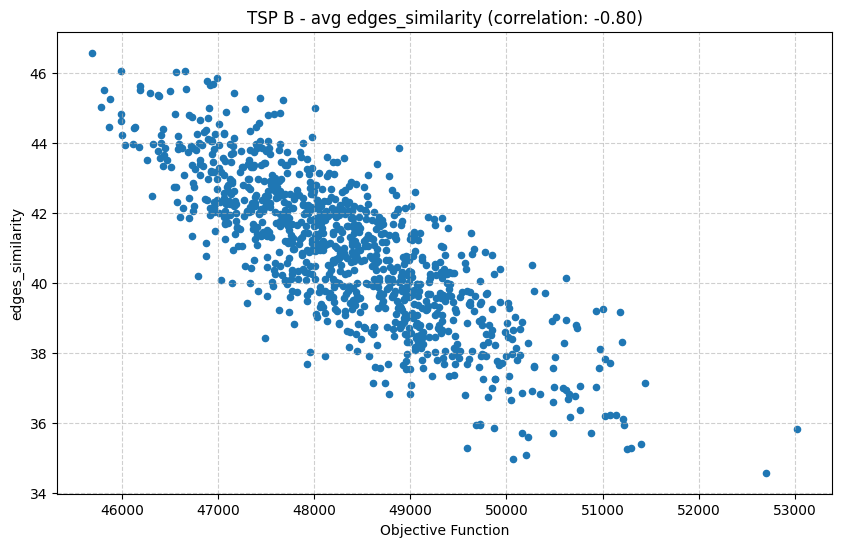

Time to calculate: 2327.2644 seconds


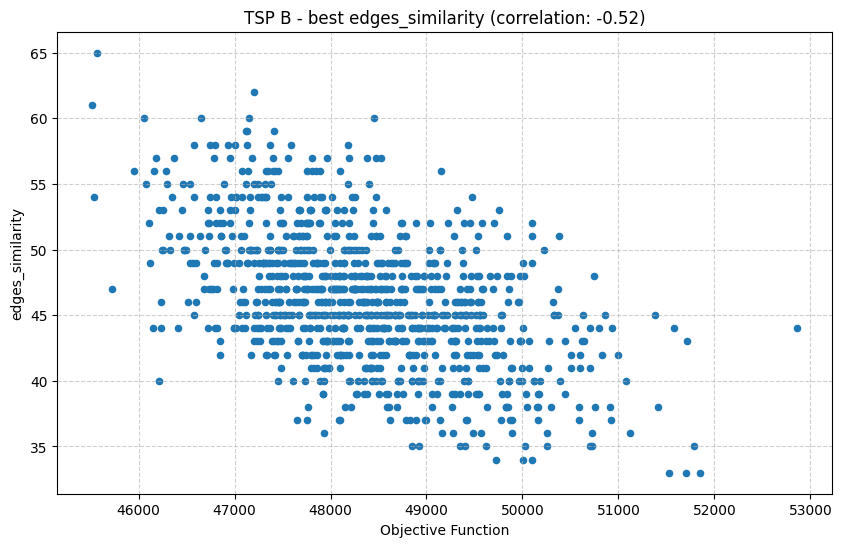

Time to calculate: 2338.6434 seconds


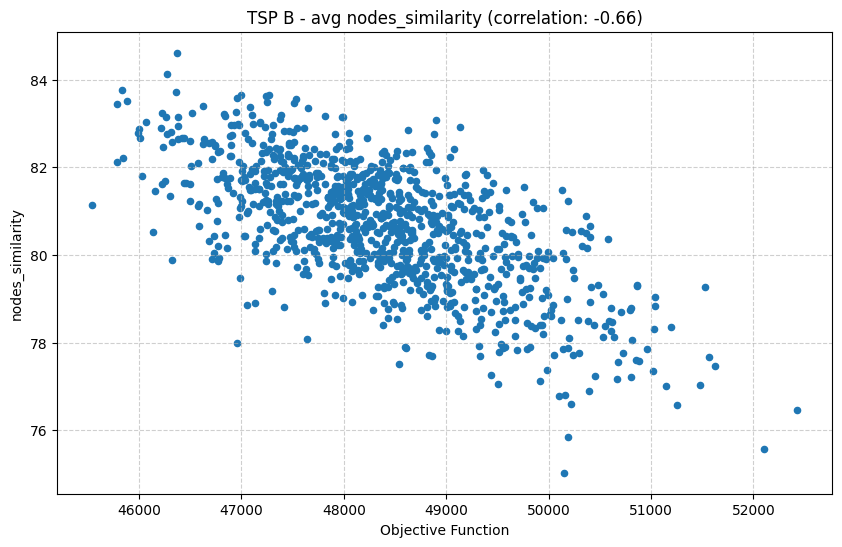

Time to calculate: 2326.2470 seconds


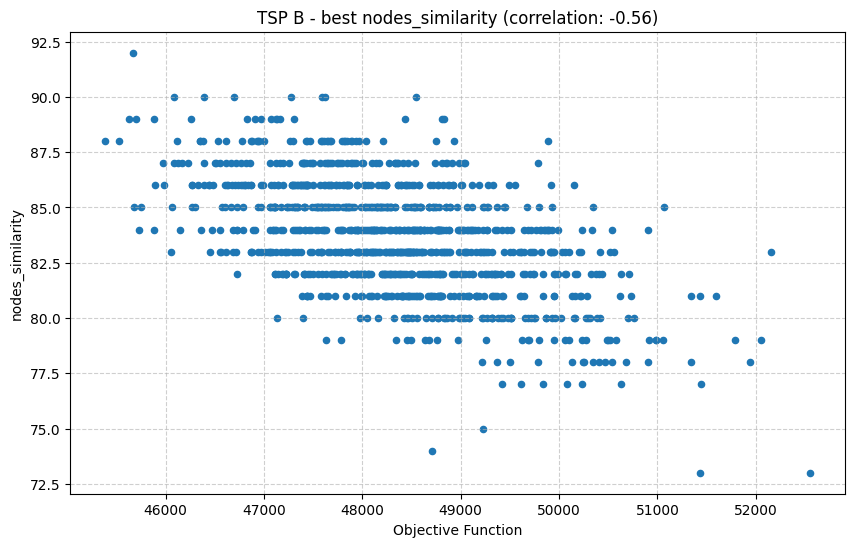

In [24]:
for similarity in ['edges_similarity', 'nodes_similarity']:
    for baseline_solution in ['avg', 'best']:
        plot_similarities(
            dataset_B,
            distance_matrix_B,
            'TSP B',
            similarity,
            baseline_solution
        )